# Basic country stats

AUTHOR: Michal Mochtak (michal.mochtak@ru.nl), Peter Rupnik (peter.rupnik@ijs.si), Nikola Ljubešić

DATE: 2024-06-24

---

In this notebook we look into specific countries and their sentiment scores on speaker- and party-level.

On the first run, the data will be downloaded from the internet. 

Next, some preprocessing will be performed so that only MPs of national parliaments are examined, and new statistics will be calculated on the filtered data.

We then plot statistics as a function of latitude, and display them on a choropleth map.

In [1]:
!pip install pandas==2.2.2 plotly seaborn scipy iso3166 numpy matplotlib
import plotly
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy.stats import pearsonr
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from iso3166 import countries
from matplotlib import colors as mcolors
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

# Download the data if a local copy does not yet exist:
if not Path("speeches.csv.zip").exists():
    from os import system
    system("wget https://huggingface.co/datasets/5roop/parlasent_data/resolve/main/speeches.csv.zip")
df = pd.read_csv("speeches.csv.zip")
df.head(4)

/tmp/ipykernel_1479698/481726710.py:18: DtypeWarning: Columns (10,11,12,13,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("speeches.csv.zip")


newdoc id  logits_pondered  logits_averaged  \
0  ParlaMint-UA_2022-12-13-m0.u1         3.795400         3.878044   
1  ParlaMint-UA_2022-12-13-m0.u2         3.480347         3.463225   
2  ParlaMint-UA_2022-12-13-m0.u3         5.323485         5.323485   
3  ParlaMint-UA_2022-12-13-m0.u4         3.718636         3.445550   

   char_length country                        Text_ID  \
0         4494      UA  ParlaMint-UA-en_2022-12-13-m0   
1         8213      UA  ParlaMint-UA-en_2022-12-13-m0   
2          190      UA  ParlaMint-UA-en_2022-12-13-m0   
3          476      UA  ParlaMint-UA-en_2022-12-13-m0   

                              ID  \
0  ParlaMint-UA_2022-12-13-m0.u1   
1  ParlaMint-UA_2022-12-13-m0.u2   
2  ParlaMint-UA_2022-12-13-m0.u3   
3  ParlaMint-UA_2022-12-13-m0.u4   

                                               Title        Date  \
0  Ukrainian parliamentary corpus ParlaMint-UA-en...  2022-12-13   
1  Ukrainian parliamentary corpus ParlaMint-UA-en...  2022-12-13   
2  Ukrainian parliamentary corpus ParlaMint-UA-en...  2022-12-13   
3  Ukrainian parliamentary corpus ParlaMint-UA-en...  2022-12-13   

            Body  ... Speaker_MP Speaker_minister Speaker_party  \
0  Unicameralism  ...         MP      notMinister             -   
1  Unicameralism  ...      notMP      notMinister             -   
2  Unicameralism  ...         MP      notMinister             -   
3  Unicameralism  ...         MP      notMinister            SN   

                Speaker_party_name Party_status Party_orientation  \
0                                -            -                 -   
1                                -            -                 -   
2                                -            -                 -   
3  Політична партія "Слуга народу"            -            Centre   

                          Speaker_ID                      Speaker_name  \
0    РусланОлексійовичСтефанчук.1975     Stefančuk, Ruslan Oleksijovyč   
1                      ЮріРатас.1978                       Ratas, Juri   
2    РусланОлексійовичСтефанчук.1975     Stefančuk, Ruslan Oleksijovyč   
3  ОлександрСергійовичКорнієнко.1984  Kornijenko, Oleksandr Serhijovyč   

  Speaker_gender Speaker_birth  
0              M          1975  
1              M          1978  
2              M          1975  
3              M          1984  

[4 rows x 28 columns]

In [2]:
# Prepare a mapper from country codes as per ISO-3166-2 to latitudes
countries = ["AT", "BA", "BE", "BG", "CZ", "DK", "EE", "ES-CT", "ES-GA", "ES-PV", "ES", "FI", "FR", "GB", "GR", "HR", "HU", "IS", "IT", "LV", "NL", "NO", "PL", "PT", "RS", "SE", "SI", "TR", "UA", ]
latitudes = [ 47.33, 44, 50.83, 43, 49.75, 56, 59, 40, 40, 40, 40, 64, 46, 54, 39, 45.17, 47, 65, 42.83, 57, 52.5, 62, 52, 39.5, 44, 62, 46, 39, 49,]
latitude_mapper = {k: v for k, v in zip(countries, latitudes)}

# Prepare a mapper from country codes as per ISO-3166-2 to ISO-3166-3:
from iso3166 import countries
iso2_to_iso3_mapper = {c.alpha2: c.alpha3 for c in countries}

# Basic filtering and averaging

In the next cell we will preprocess the data: filter on selected parameters, assign some new columns we will need in the future, and calculate some features.

In [3]:


# Filtering
# Keep only MPs
c1 = df.Speaker_MP == "MP"

# Exclude non-national parliaments:
c2 = ~df.country.isin(["ES-CT", "ES-GA", "ES-PV", ])

# Exclude chairs:
c3 = df.Speaker_role != "Chairperson"

ndf = df[
    c1 & \
    c2 & \
    c3
    ]

def map_sentiment_to_category(logit: float) -> str:
    if logit < 2:
        return "Negative"
    elif 2 <= logit < 4:
        return "Neutral"
    else:
        return "Positive"
ndf["sentiment_categorical"] = ndf.logits_pondered.apply(map_sentiment_to_category)
ndf["latitude"] = [latitude_mapper.get(i) for i in ndf.country]
ndf["Date"] = pd.to_datetime(ndf.Date)
ndf["PIGS"] = ndf.country.isin(["PT", "IT", "GR", "ES"])
def percentage_of_neutral(l: pd.Series) -> float:
    return (l == "Neutral").sum()/l.shape[0]
def percentage_of_negative(l: pd.Series) -> float:
    return (l == "Negative").sum()/l.shape[0]
def percentage_of_positive(l: pd.Series) -> float:
    return (l == "Positive").sum()/l.shape[0]
def get_female_average_per_country(df: pd.DataFrame, country: str)-> float:
    c1 = df.country == country
    c2 = df.Speaker_gender


gb1 = ndf.groupby("country").agg({
    "logits_pondered": "mean",
    "sentiment_categorical": [percentage_of_positive, percentage_of_neutral, percentage_of_negative]
}).reset_index()
gb1.columns = "country average_sentiment percentage_of_positive percentage_of_neutral percentage_of_negative".split()


gb1["latitude"] = [latitude_mapper.get(i) for i in gb1.country]
gb1["PIGS"] = gb1.country.isin(["PT", "IT", "GR", "ES"])
gb1["sentiment_score"] = gb1.percentage_of_positive - gb1.percentage_of_negative
gb1["positivity_score"] = gb1.sentiment_score / (gb1.percentage_of_positive + gb1.percentage_of_negative)
gb1

/tmp/ipykernel_1479698/727368220.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf["sentiment_categorical"] = ndf.logits_pondered.apply(map_sentiment_to_category)
/tmp/ipykernel_1479698/727368220.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf["latitude"] = [latitude_mapper.get(i) for i in ndf.country]
/tmp/ipykernel_1479698/727368220.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

country  average_sentiment  percentage_of_positive  percentage_of_neutral  \
0       AT           2.131530                0.031352               0.474208   
1       BA           2.213168                0.047828               0.511696   
2       BE           2.006709                0.043629               0.410949   
3       BG           2.264898                0.072697               0.513357   
4       CZ           2.154137                0.028028               0.507194   
5       DK           1.998965                0.035374               0.436198   
6       EE           1.832211                0.011920               0.377429   
7       ES           1.905895                0.057296               0.357545   
8       FI           2.257844                0.043077               0.540796   
9       FR           2.273828                0.052954               0.592533   
10      GB           2.535547                0.151901               0.489858   
11      GR           2.453493                0.098130               0.511301   
12      HR           2.029367                0.063078               0.404881   
13      HU           2.118631                0.066308               0.404628   
14      IS           2.048888                0.018800               0.472635   
15      IT           2.358473                0.031045               0.634465   
16      LV           2.802941                0.052736               0.760594   
17      NL           2.164109                0.063915               0.471414   
18      NO           2.193812                0.022753               0.548646   
19      PL           2.227422                0.053585               0.496650   
20      PT           1.986209                0.136353               0.318480   
21      RS           1.836136                0.046521               0.333396   
22      SE           2.024786                0.010589               0.477843   
23      SI           2.078091                0.012444               0.504231   
24      TR           1.728935                0.082144               0.299123   
25      UA           2.518539                0.094824               0.541793   

    percentage_of_negative  latitude   PIGS  sentiment_score  positivity_score  
0                 0.494440     47.33  False        -0.463088         -0.880744  
1                 0.440476     44.00  False        -0.392648         -0.804104  
2                 0.545422     50.83  False        -0.501793         -0.851866  
3                 0.413946     43.00  False        -0.341248         -0.701229  
4                 0.464778     49.75  False        -0.436750         -0.886253  
5                 0.528429     56.00  False        -0.493055         -0.874518  
6                 0.610651     59.00  False        -0.598731         -0.961706  
7                 0.585160     40.00   True        -0.527864         -0.821635  
8                 0.416127     64.00  False        -0.373050         -0.812384  
9                 0.354513     46.00  False        -0.301559         -0.740083  
10                0.358241     54.00  False        -0.206340         -0.404475  
11                0.390569     39.00   True        -0.292439         -0.598402  
12                0.532042     45.17  False        -0.468964         -0.788016  
13                0.529064     47.00  False        -0.462755         -0.777254  
14                0.508565     65.00  False        -0.489764         -0.928701  
15                0.334490     42.83   True        -0.303445         -0.830140  
16                0.186670     57.00  False        -0.133934         -0.559445  
17                0.464671     52.50  False        -0.400756         -0.758167  
18                0.428601     62.00  False        -0.405848         -0.899180  
19                0.449765     52.00  False        -0.396180         -0.787085  
20                0.545166     39.50   True        -0.408813         -0.599855  
21                0.620082     44.00  False        -0.573561

# Plotting

We investigate how traits like percentage of positive and negative sentiments correlate with latitude.

PearsonRResult(statistic=np.float64(-0.4411424760035956), pvalue=np.float64(0.024077033721566225))

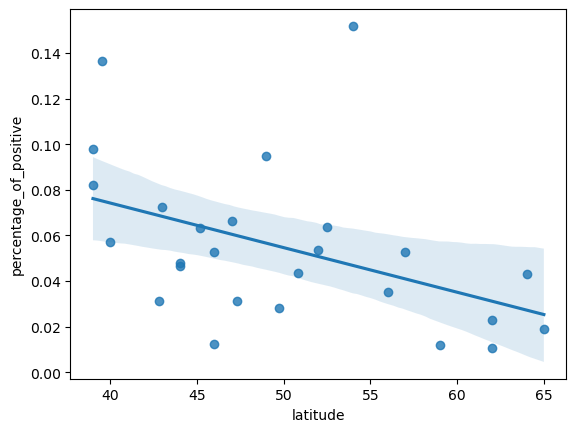

In [4]:


sns.regplot(
    data=gb1,
    x="latitude",
    y="percentage_of_positive",
)


pearsonr(
    gb1.latitude,
    gb1.percentage_of_positive,

)

PearsonRResult(statistic=np.float64(-0.15224385550968222), pvalue=np.float64(0.4578087348530287))

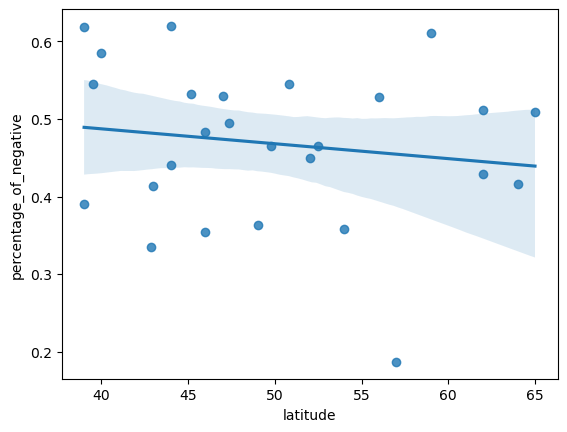

In [5]:
sns.regplot(
    data=gb1,
    x="latitude",
    y="percentage_of_negative",
    # hue="PIGS"
    # kind="scatter",
)

pearsonr(
    gb1.latitude,
    gb1.percentage_of_negative,

)

PearsonRResult(statistic=np.float64(0.30650188130858363), pvalue=np.float64(0.12777860998961366))

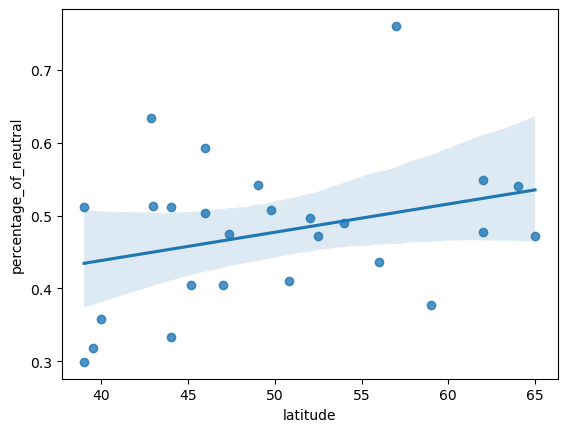

In [6]:
sns.regplot(
    data=gb1,
    x="latitude",
    y="percentage_of_neutral",
    # hue="PIGS"
    # kind="scatter",
)

pearsonr(
    gb1.latitude,
    gb1.percentage_of_neutral,

)

PearsonRResult(statistic=np.float64(-0.0023616466857844347), pvalue=np.float64(0.9908645671043474))

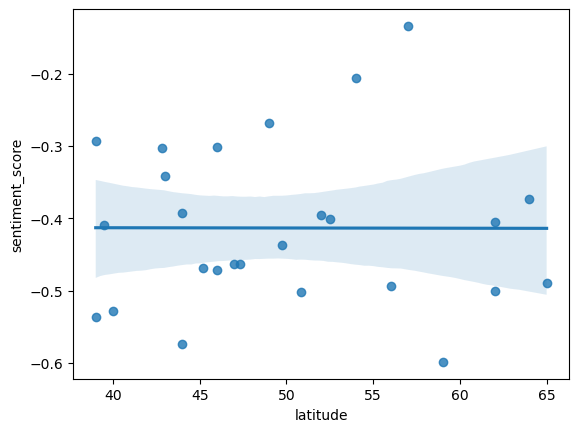

In [7]:
sns.regplot(
    data=gb1,
    x="latitude",
    y="sentiment_score",
    # hue="PIGS"
    # kind="scatter",
)


pearsonr(
    gb1.latitude,
    gb1.sentiment_score,

)

PearsonRResult(statistic=np.float64(-0.2892313230659579), pvalue=np.float64(0.15182774149494757))

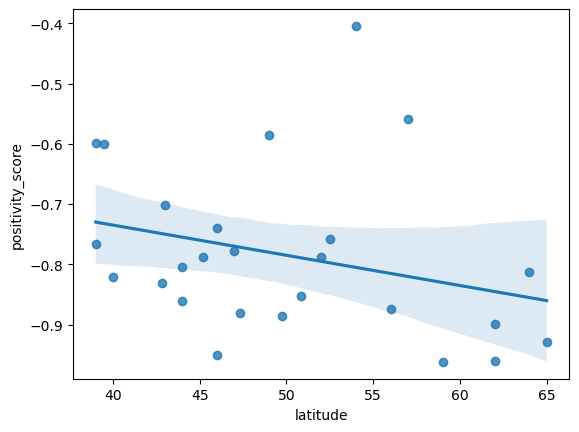

In [8]:
sns.regplot(
    data=gb1,
    x="latitude",
    y="positivity_score",
    # hue="PIGS"
    # kind="scatter",
)


pearsonr(
    gb1.latitude,
    gb1.positivity_score,

)

PearsonRResult(statistic=np.float64(0.13046135379269772), pvalue=np.float64(0.5252768074229547))

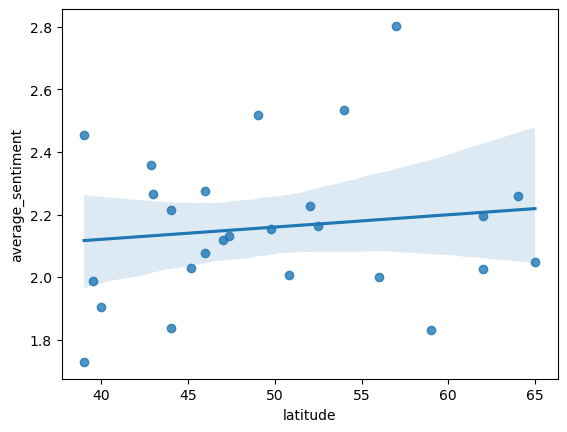

In [9]:
sns.regplot(
    data=gb1,
    x="latitude",
    y="average_sentiment",
    # hue="PIGS"
    # kind="scatter",
)


pearsonr(
    gb1.latitude,
    gb1.average_sentiment,

)

# Choropleth map of average sentiment

We will assign a three-letter code to every country in `gb1` and plot it on a choropleth map.

In [10]:
gb1["iso3"] = gb1.country.apply(lambda s: iso2_to_iso3_mapper[s])


import plotly.express as px
fig = px.choropleth(gb1,
                    locations='iso3',
                    locationmode='ISO-3',
                    color='average_sentiment',
                    color_continuous_scale='Oranges',
                    scope="europe",
                    title="Overall sentiment per country",
                    height=600,
                    width=800
                   )

# Display the map
fig.show()

# Time-based maps

Let's inspect the sentiment map in a specific year. For this we will prepare a new DataFrame from the filtered data, in which we will group the data by country as well as by year. In the next cell the data is plotted on a map.

In [11]:
gb3 = ndf.assign(Date=pd.to_datetime(ndf.Date)).set_index("Date").groupby(["country", pd.Grouper(freq="1YE")]).logits_pondered.mean().reset_index()
# column country  has to be cast to ISO-3166-3 standard for plotting:
gb3["country"] = gb3.country.apply(lambda s: iso2_to_iso3_mapper.get(s, s))
gb3["year"] = gb3.Date.apply(lambda dt: dt.year)
gb3

country       Date  logits_pondered  year
0       AUT 1996-12-31         1.927903  1996
1       AUT 1997-12-31         1.946389  1997
2       AUT 1998-12-31         2.109930  1998
3       AUT 1999-12-31         2.114496  1999
4       AUT 2000-12-31         1.786137  2000
..      ...        ...              ...   ...
324     UKR 2019-12-31         2.536370  2019
325     UKR 2020-12-31         2.437729  2020
326     UKR 2021-12-31         2.417952  2021
327     UKR 2022-12-31         2.703886  2022
328     UKR 2023-12-31         2.603660  2023

[329 rows x 4 columns]

In [12]:


# Create a figure
fig = go.Figure()

# Create a choropleth map for each year and add to the figure
years = gb3['year'].unique()
for year in years:
    gb3_year = gb3[gb3['year'] == year]
    fig.add_trace(go.Choropleth(
        locations=gb3_year['country'],
        z=gb3_year['logits_pondered'],
        locationmode='ISO-3',
        colorscale='Oranges',
        colorbar_title='Logits Pondered',
        # visible=False,
        # scope="europe",
        name=str(year)
    ))

# Make the first trace (first year) visible
fig.data[0].visible = True

# Create a slider
steps = []
for i, year in enumerate(years):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": f"Choropleth Map for {year}"}],
        label=str(year)
    )
    step["args"][0]["visible"][i] = True  # Toggle i-th trace to be visible
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Year: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    title='Choropleth Map of logits_pondered by Country and Year',
    geo={
        "scope":"europe"
    },
    height=800,  # Increase height
    width=1200   # Increase width
)

# Display the map
fig.show()


# Time trends

/tmp/ipykernel_1479698/2993204354.py:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



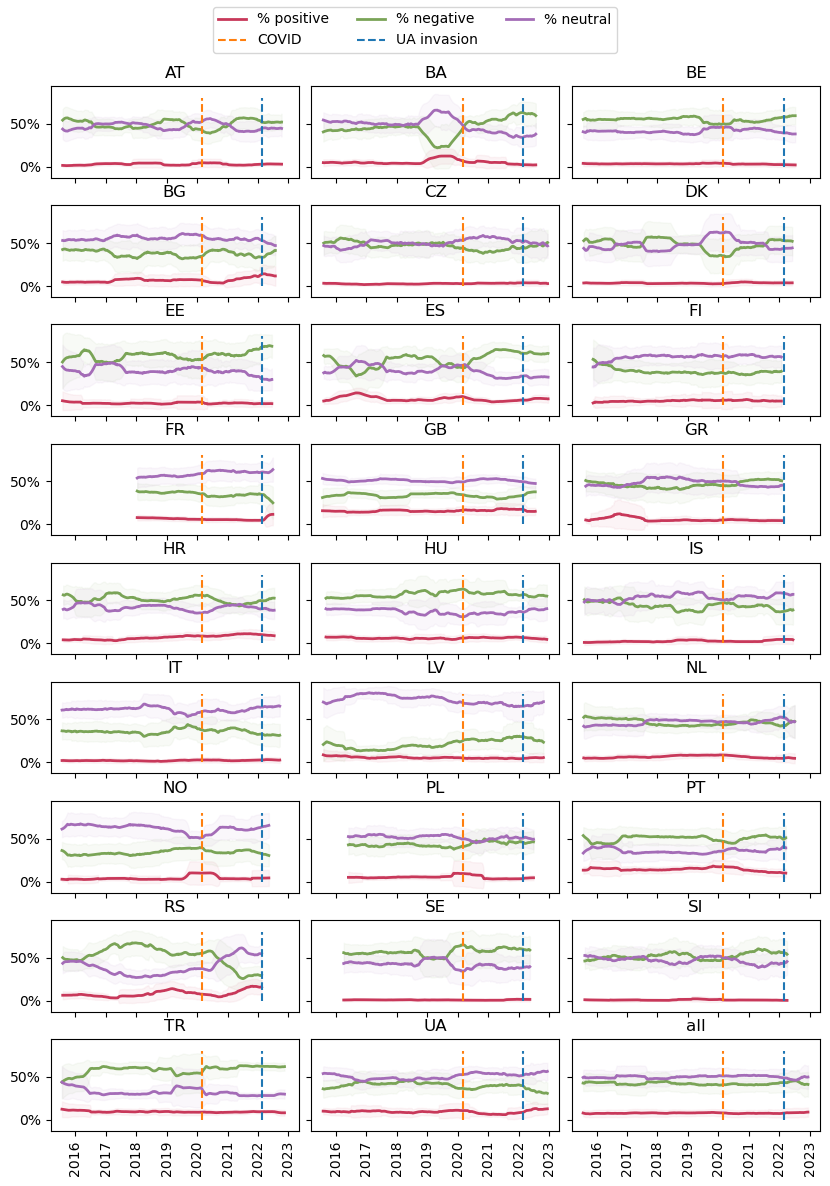

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
M=2.5
fig, axes = plt.subplots(
    ncols=3,
    nrows=9,
    sharex=True,
    sharey=True,
    figsize=(21/M, 29.7/M),
)
for ax, country in zip(
    fig.axes,
    sorted(ndf.country.unique()) + ["all"]
):
    c0  = ndf.Date >= "2015-01-01"
    c1 = ndf.Date <= "2023-01-01"
    if country == "all":
        c2 = pd.Series([True for i in c1])
    else:
        c2 = ndf.country == country
    subset = ndf[c0 & c1 & c2].copy().set_index("Date")
    gb = subset.groupby(pd.Grouper(freq="1D")).agg({
    "sentiment_categorical": [percentage_of_negative, percentage_of_neutral, percentage_of_positive]
        }).interpolate().rolling(
            window=pd.Timedelta("365D"),
            ).agg({
            ("sentiment_categorical", "percentage_of_negative"): ["mean", "std"],
            ("sentiment_categorical", "percentage_of_positive"): ["mean", "std"],
            ("sentiment_categorical", "percentage_of_neutral"): ["mean", "std"]
        })
    c4 =( gb.index >= "2020-03-01") & (gb.index <= "2022-03-01")
    for s, c in [
        ("positive", "#c8385a"),
        ("negative", "#7aa457"),
        ("neutral", "#a46cb7")
        ]:
        # Covid mean
        ax.plot(
            gb.index.values[200:],
            gb[("sentiment_categorical", f"percentage_of_{s}", "mean")].values[200:],
            label=f"% {s}",
            color=c,
            linewidth=2,
            # alpha=1,
        )
        # STD:
        ax.fill_between(
            gb.index[200:],
            gb[("sentiment_categorical", f"percentage_of_{s}", "mean")][200:] - gb[("sentiment_categorical", f"percentage_of_{s}", "std")][200:],
            gb[("sentiment_categorical", f"percentage_of_{s}", "mean")][200:] + gb[("sentiment_categorical", f"percentage_of_{s}", "std")][200:],
            color = c,
            alpha = 0.05,
            zorder=-2
        )
        from matplotlib import ticker
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    # break
    ax.vlines(pd.to_datetime("2020-03-01"), 0, 0.8, color="tab:orange", linestyles="--", label="COVID")
    ax.vlines(pd.to_datetime("2022-02-24"), 0, 0.8, color="tab:blue", linestyles="--", label="UA invasion")
    ax.set_title(country)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[0:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
order = [0,3,1,4,2]
fig.legend([lines[o] for o in order], [labels[o] for o in order], loc="upper center", ncols=3)
plt.gcf().autofmt_xdate(rotation=90, ha="center")
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.3, top=0.93)
plt.savefig("trends.pdf")
plt.show()

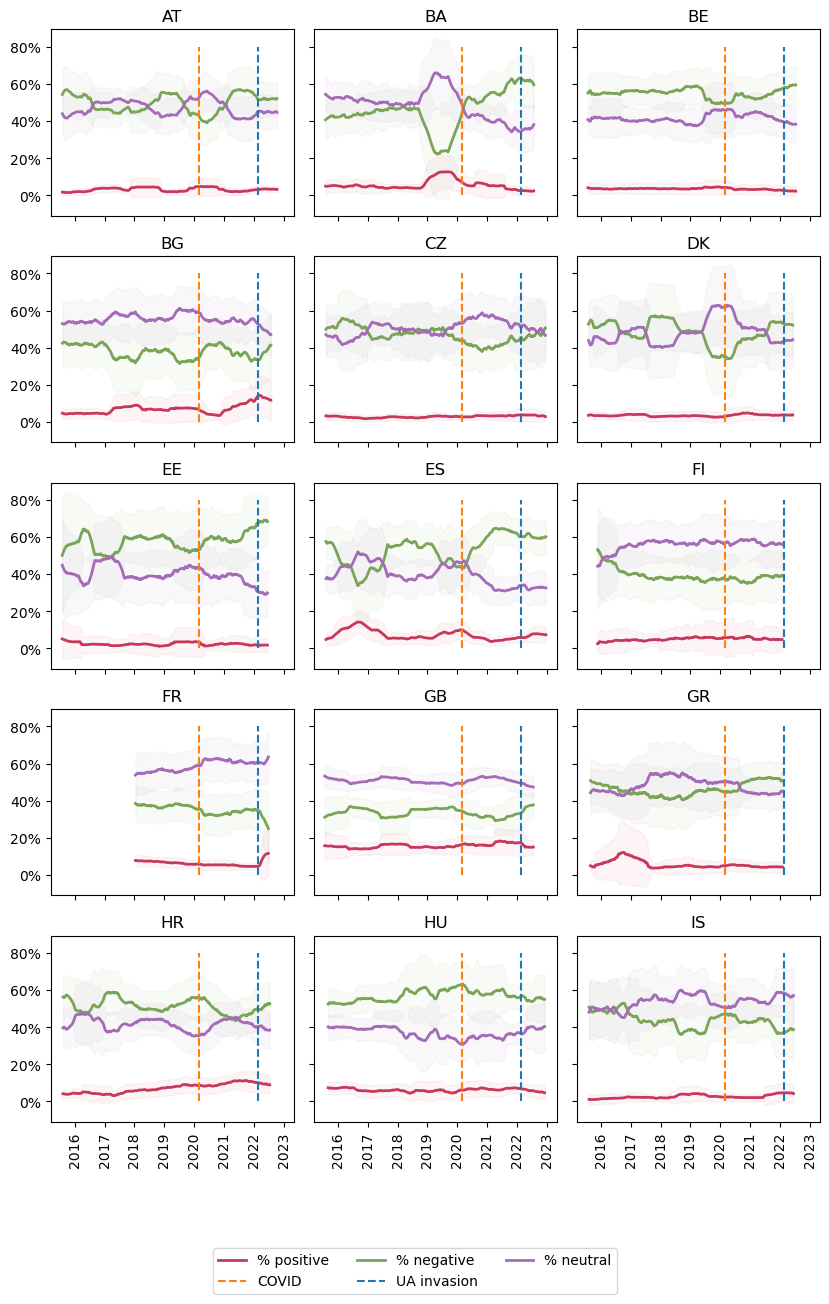

/tmp/ipykernel_1479698/3618009177.py:94: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



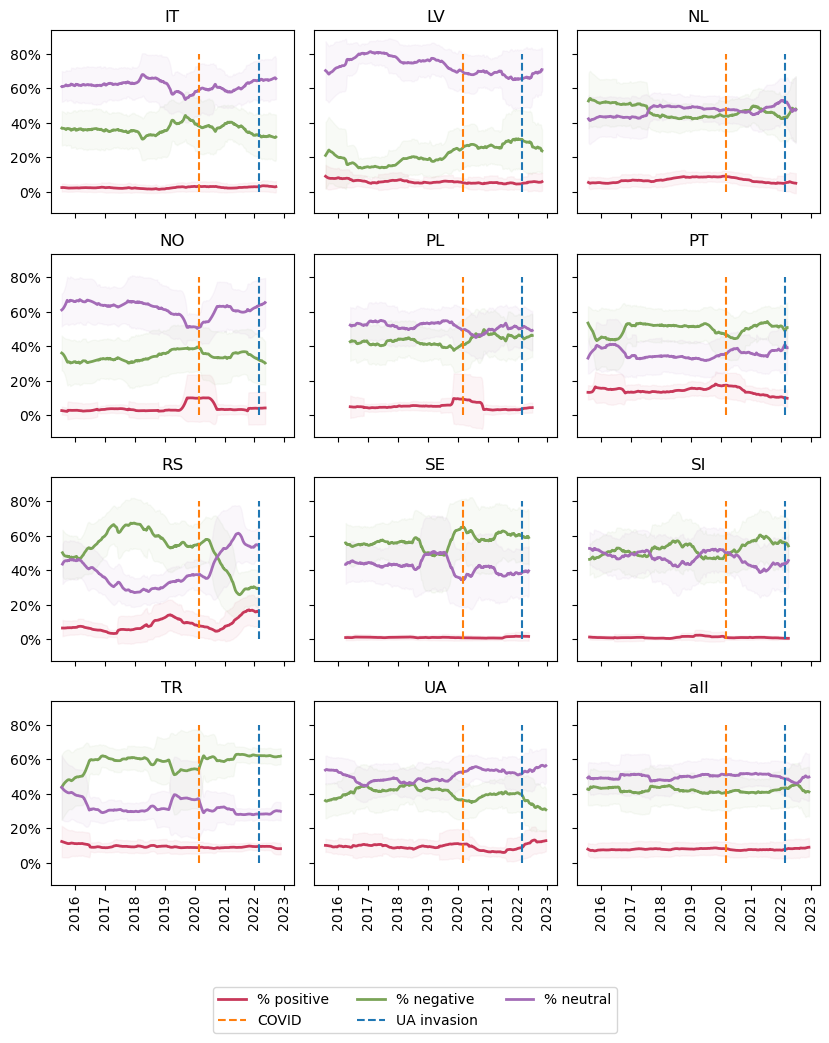

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
M=2.5
fig, axes = plt.subplots(
    ncols=3,
    nrows=5,
    sharex=True,
    sharey=True,
    figsize=(21/M, 29.7/M),
)
for ax, country in zip(
    fig.axes,
    sorted(ndf.country.unique()) + ["all"]
):
    c0  = ndf.Date >= "2015-01-01"
    c1 = ndf.Date <= "2023-01-01"
    if country == "all":
        c2 = pd.Series([True for i in c1])
    else:
        c2 = ndf.country == country
    subset = ndf[c0 & c1 & c2].copy().set_index("Date")
    gb = subset.groupby(pd.Grouper(freq="1D")).agg({
    "sentiment_categorical": [percentage_of_negative, percentage_of_neutral, percentage_of_positive]
        }).interpolate().rolling(
            window=pd.Timedelta("365D"),
            ).agg({
            ("sentiment_categorical", "percentage_of_negative"): ["mean", "std"],
            ("sentiment_categorical", "percentage_of_positive"): ["mean", "std"],
            ("sentiment_categorical", "percentage_of_neutral"): ["mean", "std"]
        })
    c4 =( gb.index >= "2020-03-01") & (gb.index <= "2022-03-01")
    for s, c in [
        ("positive", "#c8385a"),
        ("negative", "#7aa457"),
        ("neutral", "#a46cb7")
        ]:
        # Covid mean
        ax.plot(
            gb.index.values[200:],
            gb[("sentiment_categorical", f"percentage_of_{s}", "mean")].values[200:],
            label=f"% {s}",
            color=c,
            linewidth=2,
            # alpha=1,
        )
        # STD:
        ax.fill_between(
            gb.index[200:],
            gb[("sentiment_categorical", f"percentage_of_{s}", "mean")][200:] - gb[("sentiment_categorical", f"percentage_of_{s}", "std")][200:],
            gb[("sentiment_categorical", f"percentage_of_{s}", "mean")][200:] + gb[("sentiment_categorical", f"percentage_of_{s}", "std")][200:],
            color = c,
            alpha = 0.05,
            zorder=-2
        )
        from matplotlib import ticker
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    # break
    ax.vlines(pd.to_datetime("2020-03-01"), 0, 0.8, color="tab:orange", linestyles="--", label="COVID")
    ax.vlines(pd.to_datetime("2022-02-24"), 0, 0.8, color="tab:blue", linestyles="--", label="UA invasion")
    ax.set_title(country)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[0:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
order = [0,3,1,4,2]
fig.legend([lines[o] for o in order], [labels[o] for o in order], loc="lower center", ncols=3, bbox_to_anchor=(0.5, -0.1))
plt.gcf().autofmt_xdate(rotation=90, ha="center")
plt.subplots_adjust(wspace=0.05, hspace=0.3, top=0.93, bottom=0.2)
plt.tight_layout()
plt.savefig("trends_1.pdf", bbox_inches="tight")
plt.show()



%matplotlib inline
import matplotlib.pyplot as plt
M=2.5
fig, axes = plt.subplots(
    ncols=3,
    nrows=4,
    sharex=True,
    sharey=True,
    figsize=(21/M, 29.7/M*4/5),
)
for ax, country in zip(
    fig.axes,
    (sorted(ndf.country.unique()) + ["all"])[3*5:]
):
    c0  = ndf.Date >= "2015-01-01"
    c1 = ndf.Date <= "2023-01-01"
    if country == "all":
        c2 = pd.Series([True for i in c1])
    else:
        c2 = ndf.country == country
    subset = ndf[c0 & c1 & c2].copy().set_index("Date")
    gb = subset.groupby(pd.Grouper(freq="1D")).agg({
    "sentiment_categorical": [percentage_of_negative, percentage_of_neutral, percentage_of_positive]
        }).interpolate().rolling(
            window=pd.Timedelta("365D"),
            ).agg({
            ("sentiment_categorical", "percentage_of_negative"): ["mean", "std"],
            ("sentiment_categorical", "percentage_of_positive"): ["mean", "std"],
            ("sentiment_categorical", "percentage_of_neutral"): ["mean", "std"]
        })
    c4 =( gb.index >= "2020-03-01") & (gb.index <= "2022-03-01")
    for s, c in [
        ("positive", "#c8385a"),
        ("negative", "#7aa457"),
        ("neutral", "#a46cb7")
        ]:
        # Covid mean
        ax.plot(
            gb.index.values[200:],
            gb[("sentiment_categorical", f"percentage_of_{s}", "mean")].values[200:],
            label=f"% {s}",
            color=c,
            linewidth=2,
            # alpha=1,
        )
        # STD:
        ax.fill_between(
            gb.index[200:],
            gb[("sentiment_categorical", f"percentage_of_{s}", "mean")][200:] - gb[("sentiment_categorical", f"percentage_of_{s}", "std")][200:],
            gb[("sentiment_categorical", f"percentage_of_{s}", "mean")][200:] + gb[("sentiment_categorical", f"percentage_of_{s}", "std")][200:],
            color = c,
            alpha = 0.05,
            zorder=-2
        )
        from matplotlib import ticker
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    # break
    ax.vlines(pd.to_datetime("2020-03-01"), 0, 0.8, color="tab:orange", linestyles="--", label="COVID")
    ax.vlines(pd.to_datetime("2022-02-24"), 0, 0.8, color="tab:blue", linestyles="--", label="UA invasion")
    ax.set_title(country)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[0:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
order = [0,3,1,4,2]
fig.legend([lines[o] for o in order], [labels[o] for o in order], loc="lower center", ncols=3, bbox_to_anchor=(0.5, -0.1))
plt.gcf().autofmt_xdate(rotation=90, ha="center")
plt.subplots_adjust(wspace=0.05, hspace=0.3, top=0.93, bottom=0.2)
plt.tight_layout()
plt.savefig("trends_2.pdf", bbox_inches="tight")
plt.show()
